<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Curso de Qiskit</div>
        </td>
        <td>
            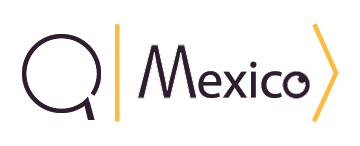
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;"> Matriz de calibración y mitigación de errores de medición </div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Bruno Ramírez</div>

# Contenido

1. [Introducción](#intro)
2. [Circuitos de calibración](#secc1)
   1. [Cómo construir circuitos de calibración en Qiskit](#secc1.1)
3. [La matriz de calibración](#secc2)
   1. [Obteniendo la matriz de calibración en Qiskit](#secc2.1)
   2. [Interpretando la matriz de calibración](#secc2.2)
4. [Mitigando errores de medición con matriz de calibración](#secc3)


<a id="intro"></a>
# Introducción

Por lo general la medición del estado de un qubit es la última parte de un algoritmo cuántico. Como todo en cómputo cuántico, las mediciones no están excentas de errores. En el caso de los qubits superconductores las mediciones hechas a través de absorción de fotones o cavidades resonantes están sujetas a errores del equipo, fallas en detectores, etc. Estos errores provocan que al usuario de una computadora cuántica se le muestre un resultado en en estado $\ket{1}$ cuando el sistema físico en realidad estaba en el estado $\ket{0}$ o viceversa. Por fortuna, los errores de medición son fáciles de corregir. 

Comencemos por mostrar cómo se ven los errores de medición. Para esto mostramos un contraste entre un circuito simple ejecutado en un simulador sin ruido(caso ideal) y en uno con un modelo de ruido pre-definido. Alternativamente se puede ejecutar en uno de los dispositivos reales de IBM. 


In [1]:
# Herramientas de Python auxiliares a Qiskit
import numpy as np
import matplotlib.pyplot as plt

# Herramientas de Qiskit necesarias para crear y ejecutar circuitos cuánticos en simulador y dispositivos
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, IBMQ  #para importar
from qiskit.providers.aer import noise
from qiskit.providers.ibmq import least_busy

from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

# Herramientas de Qiskit necesarias para crear el modelo de ruido a utilizar
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

# Definimos nuestro modelo de ruido a utilizar durante todo este notebok
def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements   
    return noise_model

# Creamos una instancia de nuestro modelo de ruido
noise_model = get_noise(0.1)

# Herramientas de Qiskit Ignis que utilizaremos
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter)
#Por si deseamos utilizar los dispositivos de IBM
#IBMQ.load_account()

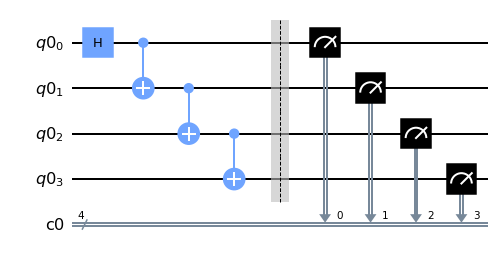

In [2]:
#Creamos un circuito de prueba que ejecutaremos en un simulador y en un dispositivo real
qreg = QuantumRegister(4)
creg = ClassicalRegister(4)
qc = QuantumCircuit(qreg,creg)
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.barrier()
qc.measure(range(0,4),range(0,4))
 
#Imprimimos nuestro circuito de prueba, debería devolver el estado entrelazado de cuatro qubits     
%matplotlib inline
qc.draw(output = "mpl")

In [3]:

simulator = Aer.get_backend("qasm_simulator")

# Ejecución en simulador sin ruido
sim_counts = execute(qc, backend = simulator, shots = 1024, optimization_level = 0).result().get_counts()

# Ejecución en simulador con ruido
noise_counts = execute(qc, backend = simulator, shots = 1024, optimization_level = 0, noise_model = noise_model).result().get_counts()



# Para ejecución en dispositivo real de IBM, buscamos el menos ocupado

#provider = IBMQ.get_provider('ibm-q')

#device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and 
                                  # not x.configuration().simulator and x.status().operational==True))
    
#print("Ejecutando en el dispositivo menos ocupado: ", device)
#device_job = execute(qc, backend = qcomp, shots = 1024, optimization_level = 0)
#device_counts = device_job.result().get_counts()
#job_monitor(device_job)


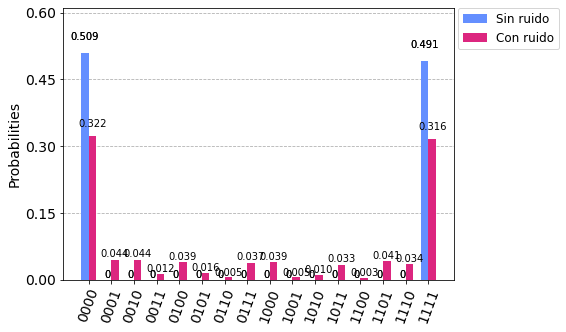

In [4]:
# Comparación de cuentas en los dispositivos con y sin ruido
plot_histogram([sim_counts, noise_counts], legend = ["Sin ruido","Con ruido"])

Aquí vemos que el circuito ejecutado en el dispositivo con ruido (o real) devuelve valores distintos de los esperados en algunas ocasiones. Gran parte de estos errores suelen atribuirse a errores de medición. Este comportamiento es característico del dispositivo modelo de ruido generado. Asimismo podemos correr el circuito en un dispositivo real para ver cual es su comportamiento característico. 

A lo largo de este Notebook nos centraremos en hacer mitigación de errores con modelos de ruido creados por nosotros.

<a id="secc1"></a>
# Circuitos de calibración

Como todo en la vida, la corrección de algo comienza por entender que está pasando. Esto es lo que nos perimte hacer la función `complete_meas_cal()` y los circuitos cuánticos que se nos devuelven. 


### Función:  `complete_meas_cal(qubit_list=None, qr=None, cr=None, circlabel='')`:
> __¿Qué hace?__: Para un número determinado de qubits ($n=4$ en nuestro caso), esta función nos devuelve $2^n$ circuitos que generan cada uno de los elementos de la base como resultado.
    
> __¿Qué argumentos toma?__ 
- ``qubit_list (Optional[List[int]])``: La lista de qubits sobre la cual se hará la correción de errores. Si no se da un valor de `qubit_list` pero si de `qr` se asume que se usará todo el registro cuántico.
- ``qr (Union[int, List[QuantumRegister], None])``: Nombre o tamaño del registro cuántico a utilizar.
- ``cr (Union[int, List[ClassicalRegister], None])``: Nombre o tamaño del registro clásico a utilizar.
- ``circlabel (str)``: Una cadena de caracteres que se agregará al nombre de cada circuito para identificarlos.
    
> __¿Qué devuelve?__

Devuelve una tupla con dos listas. La primera de las listas está compuesta de $2^n$ objetos `QuantumCircuit` que generan cada uno de los estados de la base, mientras que la segunda lista está compuesta de `str`, cadenas que identifican a cada circuito de calibración.


<a id="secc1.1"></a>
## Cómo construir circuitos de calibración en Qiskit


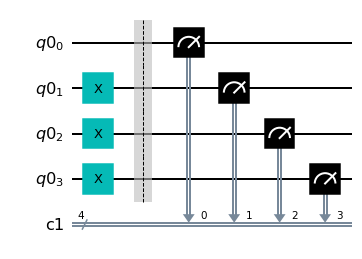

In [5]:
#####################
# complete_meas_cal #
#####################

# Creamos nuestros 16 circuitos de calibración
calcircs, calcircs_label = complete_meas_cal(qubit_list=[0,1,2,3], qr=qreg, cr=None, circlabel='calcirc_meas')

# Imprimimos el circuito número 15, que generará como salida el estado |1110>
calcircs[14].draw(output = "mpl")

<a id="secc2"></a>
# La Matriz de calibración

Construir los circuitos de calibración no nos permite entender por completo el comportamiento ruidoso de nuestro dispositivo. Para eso hay que ejecutar cada uno de los circuitos y ver qué sucedio con ellos, y así tendremos información del comportamiento. La clase __CompleteMeasFitter__ de Qiskit nos perimte hacer esto último.

### Clase:  `CompleteMeasFitter(results, state_labels, qubit_list=None, circlabel='')`:
> __¿Qué hace?__: Una vez que se ejecutaron los circuitos de calibración en un dispositivo ruidoso, esta clase permite tomar los resultados y generar un objeto que contiene una matriz de calibración y un filtro de calibración. Este objeto es útil para conocer completamente y posteriormente corregir los errores.
    
> __¿Qué parámetros de construcción tiene?__ 
- ``results (Union[Result, List[Result]])``: Los resultados que se obtienen al correr los circuitos de calibración.
- ``state_labels (List[str]) ``: Lista de los identificadores de cada uno de los circuitos de calibración, `calcircs_label`.
- ``qubit_list (Optional[List[int]]) ``: Lista de qubits para los cuales se generará el objeto, dependiendo de cuantos qubits sea dependerá la dimensión de la matriz de calibración.
- ``circlabel (str)``: Una cadena de caracteres que se agregará al nombre de cada circuito para identificarlos.
    
> __¿Qué construye?__

Construye un objeto que contiene dos atributos principales. Inicializa una matriz de calibración a partir de los resultados que se le entregaron, `matcal = measfitter.cal_matrix`, y a partir de esta devuelve un filtro aplicable a los resultados para corregir los errores `filtro = measfitter.filter`. Este filtro se aplica a los resultados mediante un método de la clase, `res_corregido = filtro.apply(results)


<a id="secc2.1"></a>
## Obteniendo la matriz de calibración en Qiskit

Demostración de cómo cambia la apariencia de una matriz de calibración antes y después de agregar un modelo de ruido, posiblemente importe el modelo de ruido de algún dispositivo real.


In [6]:
# Ejecutando cada uno de los circuitos de calibración en un dispositivo con modelo de ruido
cal_results = execute(calcircs, backend = simulator, shots = 1024, noise_model = noise_model).result()

######################
# CompleteMeasFitter #
######################


# Creando la matriz de calibración a partir de los resultados.
meas_fitter = CompleteMeasFitter(cal_results, calcircs_label, circlabel='calcirc_meas')


In [7]:
#Si se quiere visualizar la matriz de calibración con valores numéricos, un poco grande e intimidante

#print(meas_fitter.cal_matrix)


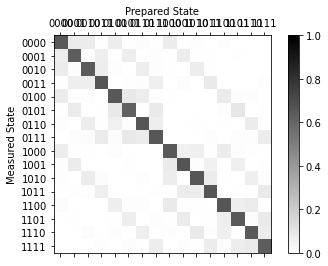

In [8]:
# Representación gráfica de la matriz de calibración
meas_fitter.plot_calibration()

<a id="secc2.2"></a>
## Interpretando el contenido de la matriz de calibración

__(PENDIENTE A PARTIR DE AQUÍ)__

Explicación de qué significan los colores en la matriz de calibración, comentarios acerca de fidelidad de medición a través del método `readout_fidelity()`.

In [9]:
# Uso del método readout_fidelity()

<a id="secc3"></a>
# Mitigando errores de medición con matriz de calibración

Sólo hablar de la mitigación con pseudo inversa, la mitigación tensorada/tensorial quedará pendiente para el siguiente notebook, en el que se incluyen otras técnicas de mitigación.


In [10]:
# Código para mitigación con la pseudo-inversa

<a id="secc3"></a>
# Referencias
***
- [1] https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html
- [2] The Qiskit Team (2021, June 22). Measurement Error Mitigation. Consultado en https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="02_Relajacion_y_Decoherencia.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: 02_Relajacion_y_Decoherencia
            </a>
            </div>
        </td>
        <td>
            <div style="text-align: right;">
            <a href="04_Técnicas_de_Mitigación.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                Notebook siguiente: 04_Técnicas_de_Mitigación >>
            </a>
            </div>
        </td>
    </tr>
</table>